# Additional Data Creator Workbook

In [1]:
# Import the relevent packages
import os # File/directory operations
import ntpath # File/directory operations
import imgaug as ia # Image augmentations
import imgaug.augmenters as iaa # Image augmentations
import imageio as imio # Reading images
import numpy as np # Matrix operations
from skimage import data # Image operations
from skimage.color import rgb2gray # RGB image to grey
from skimage.transform import resize # Resize images
import matplotlib.pyplot as plt # for visualisation
import pandas as pd # Data manipulations
from scipy import stats #not used but helps with debuging


In [2]:
# Set the input and output paths for later reference
dataPaths = {'InputImage':os.path.abspath(os.path.join('Data','Images')),
             'InputAnnot':os.path.abspath(os.path.join('Data','Annotations')),
             'OutputImage':os.path.abspath(os.path.join('Output','Images')),
             'OutputAnnot':os.path.abspath(os.path.join('Output','Annotations')),
             'XTrain':os.path.abspath(os.path.join('OutputData','XTrain')),
             'yTrain':os.path.abspath(os.path.join('OutputData','yTrain')),
             'XTest':os.path.abspath(os.path.join('OutputData','XTest')),
             'yTest':os.path.abspath(os.path.join('OutputData','yTest'))}

In [3]:
def getFilesInDir(dir):
    """This function will return a list of files in the given dir"""
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(dir):
        for file in f:
            files.append(os.path.join(r, file))
    return files

def validateImagePairs(imPairTuple, width):
    """This function reads the image and resizes it to the closest %32=0 for the specified width"""
    imgDir , annotDir = imPairTuple
    img = imio.imread(imgDir)
    annot = rgb2gray(imio.imread(annotDir))*255
    
    widthScaleRatio = width / img.shape[1]
    heightNew = (widthScaleRatio * (img.shape[0]))
    heightNew = heightNew - (heightNew%32)
    
    annotNew = resize(annot, (heightNew, width),mode='edge', anti_aliasing=False,
                               anti_aliasing_sigma=None,preserve_range=True,
                               order=0).astype(int)
    df = (pd.DataFrame(annotNew))
    _, b = pd.factorize(df.values.T.reshape(-1, ))  

    # print(df.apply(lambda x: pd.Categorical(x, b).codes).values.shape)
    annotNewOut = df.apply(lambda x: pd.Categorical(x, b).codes).values
    
    
    return (resize(img, (heightNew, width), anti_aliasing=True),
            annotNewOut)

def augment_seg(imSegTuple, filterSeq):
    """This function applies a 'filter' to the input image and its annotation """
    img , seg = imSegTuple  
    img = img*255
    img = img.astype(np.uint8)
    aug_det = filterSeq.to_deterministic() 
    image_aug = aug_det.augment_image( img )
    segmap = ia.SegmentationMapOnImage( seg , nb_classes=len(np.unique(seg)), shape=img.shape )
    segmap_aug = aug_det.augment_segmentation_maps( segmap )
    segmap_aug = segmap_aug.get_arr_int()
    return (image_aug , segmap_aug)

def path_leaf(path):
    """This function gets the file name from a path"""
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def saveAugmentOutputs(augmentImagePairs, originalFileNamePairs, suffex, outImagPath, outAnnotPath):
    """This function saves the augmented images"""
    for i in range(0, len(augmentImagePairs)):
        img = augmentImagePairs[i][0]
        fileName = path_leaf(originalFileNamePairs[i][0])
        fileNameSplit = fileName.split('.')
        imFileName = outImagPath+'\\'+fileNameSplit[0]+suffex+'.'+fileNameSplit[1]
        imio.imsave(imFileName, img)
        #print(imFileName)
        annot = augmentImagePairs[i][1]
        annot = flattenSegImage(annot,getSegClasses(annot))
        fileNameAnnot = path_leaf(originalFileNamePairs[i][1])
        fileNameAnnotSplit = fileNameAnnot.split('.')
        annotFileName = outAnnotPath+'\\'+fileNameAnnotSplit[0]+suffex+'.'+fileNameAnnotSplit[1]
        annot = annot.astype(np.uint8)
        imio.imwrite(annotFileName, annot)

def ShowAugmentCompare(originalTup, newTup):
    """This function shows a comparason of orginal vs augmented images and annotations"""
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(originalTup[0])
    ax[0].set_title("Original image")
    ax[1].imshow(newTup[0])
    ax[1].set_title("New image")
    ax[2].imshow(originalTup[1], cmap='gray')
    ax[2].set_title("Original annotation")
    ax[3].imshow(newTup[1], cmap='gray')
    ax[3].set_title("New annotation")
    plt.tight_layout()
    plt.show()
    

def getSegClasses(seg):
    segUnique = np.unique(seg)
    #print(segUnique)
    output = {}
    for i in range(0,len(segUnique)):
        output[segUnique[i]] = i
    return output
        
    
def flattenSegImage(seg, classes):
    k = np.array(list(classes.keys()))
    v = np.array(list(classes.values()))
    sidx = k.argsort()
    output = v[sidx[np.searchsorted(k,seg,sorter=sidx)]]
    
    #print(stats.describe(seg).mean)
    #print(stats.describe(output).mean)
    return output

In [4]:
# This will create a list of tuples for the input images, it will associate an image with 
# its annotation given the naming convention is followed

print('Reading and resizing input files...')

filePairPaths = list(zip(getFilesInDir(dataPaths['InputImage']), getFilesInDir(dataPaths['InputAnnot'])))
inputImagePairs = []
for tup in filePairPaths:
    inputImagePairs.append(validateImagePairs(tup,1600))
    
print('Read '+str(len(inputImagePairs)*2)+' files.')

Reading and resizing input files...
Read 16 files.


In [13]:
# See https://github.com/aleju/imgaug#example-images for details

print('Createing filters...')

filters = {
    'a':None,
    'b':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),]), # horizontally flip ,
    'c':iaa.Sequential([iaa.Fliplr(1),]), # horizontally flip ,
    'd':iaa.Sequential([iaa.Flipud(1),]), # vertically flip ,
    #'e':iaa.Sequential([iaa.PerspectiveTransform(scale=0.1, keep_size=True),]),# Perspective Transform,
    #'f':iaa.Sequential([iaa.PiecewiseAffine(scale=0.015),]),# Piecewise Affine
    #'g':iaa.Sequential([iaa.Multiply((0.5, 1.5)),]),# Make image brighter/darker
    #'h':iaa.Sequential([iaa.AddToHueAndSaturation((-15, 15)),iaa.PiecewiseAffine(scale=0.015), iaa.PerspectiveTransform(scale=0.1, keep_size=True)]),# Shift the hue,
    #'i':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),iaa.Fliplr(1),iaa.AddToHueAndSaturation((-15, 15))]),
    #'j':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),iaa.Fliplr(1),iaa.Flipud(1)]),
    #'k':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),iaa.Fliplr(1),iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.1, keep_size=True)]),
    #'l':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.PiecewiseAffine(scale=0.015)]),
    #'m':iaa.Sequential([iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.PiecewiseAffine(scale=0.015),iaa.GammaContrast((0.5, 1.5))]),
    #'n':iaa.Sequential([iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.PiecewiseAffine(scale=0.015),iaa.GammaContrast((0.5, 1.5)),iaa.AddToHueAndSaturation((-15, 15))]),
    #'o':iaa.Sequential([iaa.PiecewiseAffine(scale=0.015),iaa.AddToHueAndSaturation((-15, 15))]),
    #'p':iaa.Sequential([iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.PiecewiseAffine(scale=0.015),iaa.AddToHueAndSaturation((-15, 15))]),
    #'q':iaa.Sequential([iaa.Fliplr(1),iaa.AddToHueAndSaturation((-15, 15))]),
    #'r':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.GammaContrast((0.5, 1.5)),iaa.AddToHueAndSaturation((-15, 15))]),
    #'s':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1), iaa.GammaContrast((0.5, 1.5)),iaa.AddToHueAndSaturation((-15, 15))]),
    #'t':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1), iaa.PiecewiseAffine(scale=0.015),iaa.AddToHueAndSaturation((-15, 15))]),
    #'u':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1), iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.Multiply((0.5, 1.5))]),
    #'v':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),iaa.AddToHueAndSaturation((-15, 15))]),
    #'w':iaa.Sequential([iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.1, keep_size=True)]),
    #'x':iaa.Sequential([iaa.Fliplr(1),iaa.AddToHueAndSaturation((-15, 15))]),
    #'y':iaa.Sequential([iaa.PiecewiseAffine(scale=0.015),iaa.GammaContrast((0.5, 1.5))]),
    #'z':iaa.Sequential([iaa.MotionBlur(k=10,angle=[-90, 90]),iaa.PerspectiveTransform(scale=0.1, keep_size=True),iaa.GammaContrast((0.5, 1.5)),iaa.AddToHueAndSaturation((-15, 15))])
}

print(filters)

Createing filters...
{'a': None, 'b': Sequential(name=UnnamedSequential, random_order=False, children=[Convolve(name=UnnamedMotionBlur, parameters=[<function MotionBlur.<locals>.create_matrices at 0x0000019100316BF8>, function], deterministic=False)], deterministic=False), 'c': Sequential(name=UnnamedSequential, random_order=False, children=[Fliplr(name=UnnamedFliplr, parameters=[Deterministic(int 1)], deterministic=False)], deterministic=False), 'd': Sequential(name=UnnamedSequential, random_order=False, children=[Flipud(name=UnnamedFlipud, parameters=[Deterministic(int 1)], deterministic=False)], deterministic=False)}


In [15]:
for key, value in filters.items():
    if(value==None):
        #print(key)
        saveAugmentOutputs(inputImagePairs, filePairPaths, key, dataPaths['OutputImage'],dataPaths['OutputAnnot'])
    else:
        print('Applying filter \''+ key +'\' to input')
        outputAugment = []
        for tup in inputImagePairs:
            outputAugment.append(augment_seg(tup, value))
        print('Saving output of filter \''+ key +'\'')
        saveAugmentOutputs(outputAugment, filePairPaths, key, dataPaths['OutputImage'],dataPaths['OutputAnnot'])
        

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Applying filter 'b' to input
Saving output of filter 'b'
Applying filter 'c' to input
Saving output of filter 'c'
Applying filter 'd' to input
Saving output of filter 'd'


In [16]:
from sklearn.model_selection import train_test_split # setting up the test and train data

print('Spilliting train and test sets')
fileOutputPaths = list(zip(getFilesInDir(dataPaths['OutputImage']), getFilesInDir(dataPaths['OutputAnnot'])))
df = pd.DataFrame(fileOutputPaths, columns=['X', 'y'])
X = df['X']
y = df['y']

Spilliting train and test sets


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [18]:
from shutil import copyfile
import errno

def copyFileToDir(df, path):
    for file in df.values:
        print(file)
        dest = path+'\\'
        print(dest)
        dest = dest+path_leaf(file)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        copyfile(file, dest)

In [19]:
print('Copying train/test output')
copyFileToDir(X_train,dataPaths['XTrain'])
copyFileToDir(X_test,dataPaths['XTest'])
copyFileToDir(y_train,dataPaths['yTrain'])
copyFileToDir(y_test,dataPaths['yTest'])

Copying train/test output
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Images\2b.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Images\5b.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Images\3a.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Images\8c.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Annotations\6b.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Annotations\4d.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Annotations\4a.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Annotations\3d.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Proj

[0 1 2 3 4 5 6 7 8 9]


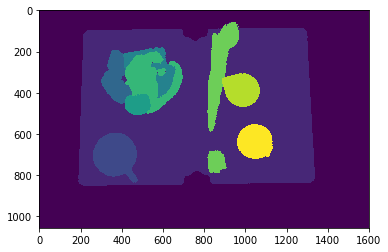

In [12]:
img = imio.imread('1a.png')
print(np.unique(img))
plt.imshow(img)